In [238]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import importlib

import matplotlib.patches as mpatches
import sys
from urllib.request import urlretrieve
from pydrake.all import (
    DiagramBuilder, ConnectPlanarSceneGraphVisualizer, Simulator, RigidTransform, LeafSystem, BasicVector,
    MultibodyPlant,SceneGraph,
    JacobianWrtVariable, RollPitchYaw, VectorLogSink, SpatialInertia, UnitInertia, Box, CoulombFriction, ContactModel,Sphere,
    WitnessFunctionDirection, UnrestrictedUpdateEvent, MathematicalProgram, le,SnoptSolver, DirectCollocation, Solve,eq,ge,sin,cos, PiecewisePolynomial,Quaternion
)

from manipulation.meshcat_cpp_utils import AddMeshcatTriad

So here we are going to create a ball bouncer trajectory optimizer
This hould take input from the ball 

In [239]:
#returns the position and the velocity of teh ball at the bounce location.
def BounceManip(q_m,q_mdot,q_b,q_bdot,h,e,g):
    theta = q_m[2]
    normal =np.array([sin(theta),-cos(theta)])
    tangent = np.array([cos(theta),sin(theta)])
    Vel_ball = q_bdot + np.array([0,-h*g])
    
    Vel_relative = Vel_ball - np.array(q_mdot[0:2])
    Veln = -normal.dot(Vel_relative)*e
    Velt = tangent.dot(Vel_ball)

    Pos_Ball = q_b+ np.array([h*q_bdot[0],h*q_bdot[1]-1/2*g*h*h])

    return Pos_Ball,Veln*normal+Velt*tangent

#returns the velocity and the position of the ball at the bounce location
def BounceFloor(q_m,q_mdot,h,e,g):
    Vel_ball = q_mdot[3:5] + [0,-h*g]
    
    

    Pos_Ball = np.array(q_m[3:5]) + np.array([h*q_mdot[3],h*q_mdot[4]-1/2*g*h*h])

    return Pos_Ball, [Vel_ball[0],-Vel_ball[1]*e]


[-0.02282995 -0.6796102 ]
[ 0.00245147 -0.79140496]
[ 0.00397571 -1.31991945]
[ 0.00162433 -1.50657602]
[ 1.32141761e-03 -1.59294476e+00]
[ 9.07651433e-04 -1.59129297e+00]
[ 1.87525419e-04 -1.47834636e+00]
[ 6.23342423e-04 -1.09044062e+00]
[ 0.00514316 -0.0051442 ]


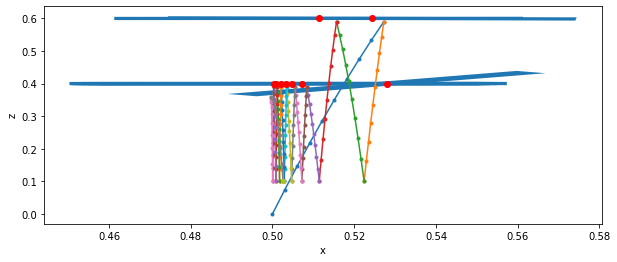

In [277]:
# Ball contraints

m = 1 #kg
r = .1 #rad

g = 9.81 #m/s^2

e = .8 #coeff of resitution

x0 =.1 #start in m
z0 =1 #start in m

N = 10 #number of bounces

#q_m => x_m, z_m, theta_m, x_b, z_b, 
# q_mdot => x_mdot, z_mdot, theta_mdot, x_bdot,z_bdot]
#This if for bounces on the floor
#q_b => x_b z_b

prog = MathematicalProgram()
h = prog.NewContinuousVariables(2,N,'h')


prog.AddBoundingBoxConstraint(0.001,10,h)

q_m = prog.NewContinuousVariables(5,N,'q_m')

q_mdot = prog.NewContinuousVariables(5,N,'q_mdot')

q_b = prog.NewContinuousVariables(2,N,'q_b')
q_bdot = prog.NewContinuousVariables(2,N,'q_bdot')

x_pos =np.ones((10,1))*.5

#This is the constraints for the Z
prog.AddConstraint(ge(q_m[1,:],.4)).evaluator().set_description('Min Manip Z ')
prog.AddConstraint(le(q_m[1,:],.6)).evaluator().set_description('Max Manip Z ')
prog.AddConstraint(ge(q_m[0,:],.2)).evaluator().set_description('Min Manip Z ')
prog.AddConstraint(le(q_m[0,:],.7)).evaluator().set_description('Max Manip Z ')

#Here are constraints for the Rotation
prog.AddConstraint(le(q_m[2,:],np.pi/4)).evaluator().set_description('Max Manip theta ')
prog.AddConstraint(ge(q_m[2,:],-np.pi/4)).evaluator().set_description('Min Manip theta ')

initialqb = [.5,0]
initialq_bdot = np.array([.2,5])

initialen = initialq_bdot.dot(initialq_bdot)*m/2


for i in range(N-1):
    NewPos, newVel = BounceManip(q_m[:,i],q_mdot[:,i],q_b[:,i],q_bdot[:,i],h[0,i],e,g)
    theta = q_m[2,i]
    Normal = np.array([sin(theta),-cos(theta)])
    tangent =  np.array([cos(theta),sin(theta)])
    
    #Add a contraint to make sure the ball bounces from the the hand to the floor
    prog.AddConstraint(eq(q_mdot[3:5,i], newVel)).evaluator().set_description(' Manip Vel ' + str(i))
    prog.AddConstraint(eq(q_m[3:5,i], NewPos)).evaluator().set_description(' Manip Pos '+ str(i) )
    normdist = np.array((q_m[3:5,i]-q_m[0:2,i])).dot(Normal)
    
    prog.AddConstraint(normdist == r*r).evaluator().set_description('Manip Bounce '+ str(i) )
    

    tangentdist = np.array((q_m[3:5,i]-q_m[0:2,i])).dot(tangent)
    
    prog.AddConstraint(tangentdist >= -.05).evaluator().set_description('Min Manip Distance '+ str(i))
    prog.AddConstraint(tangentdist <= .05).evaluator().set_description('Max Manip Distance ' + str(i) )

    prog.AddLinearConstraint(q_mdot[0,i] >= -3)
    prog.AddLinearConstraint(q_mdot[1,i] <= 0)
    prog.AddLinearConstraint(q_mdot[1,i] >= -2)
    prog.AddLinearConstraint(q_mdot[0,i] <= 2)
    Vel_ball = q_bdot[1,i] - h[0,i]*g


    #The ball needs to be still traveling upwards when hit
    prog.AddConstraint(Vel_ball >= 0.01).evaluator().set_description('Pos Vel '+ str(i))


    ball_floorPos, ball_floorVel = BounceFloor(q_m[:,i],q_mdot[:,i],h[1,i],e,g)
    #Add a contraint to make the ball bounce on to the manipulator
    prog.AddConstraint(eq(q_b[:,i+1]- ball_floorPos ,0)).evaluator().set_description('Floor Vel ' + str(i))
    prog.AddConstraint(eq(q_bdot[:,i+1] , ball_floorVel)).evaluator().set_description('FloorPos ' + str(i) )
    prog.AddConstraint(q_b[1,i+1] == r).evaluator().set_description('Floor Bounce ' + str(i))

    prog.AddCost(100*(q_b[0,i+1]-x_pos[i])**2)
    #prog.AddCost(.1*q_bdot[0,i+1]**2)

    energy= q_mdot[3:5,i].dot(q_mdot[3:5,i])*m/2 + q_m[4,i]*m*g
    timestepChange = q_m[0:2,i]-q_m[0:2,i+1]
    distancesqrd = timestepChange.dot(timestepChange)
    value = 10*distancesqrd

    #prog.AddCost(10*(energy-initialen)**2)
    prog.AddCost(10*q_mdot[0:2,i].dot(q_mdot[0:2,i]))
    #cost to how far you are from the previous point
    #prog.AddCost(value)
    #cost to how much how far you are from the ball
    #prog.AddCost(10*q_mdot[0:2,i].dot(q_mdot[3:5,i]))

    prog.AddCost(30*q_bdot[0,i+1]**2)
    prog.AddCost(100*(q_m[0,i]-q_b[0,i+1])**2)
    #prog.AddCost(-100*(h[0,i]+h[1,i]))

    
    



prog.AddConstraint(eq(q_b[:,0],initialqb))
prog.AddConstraint(eq(q_bdot[:,0],initialq_bdot))


for i in range(N-1):
    q_m_guess = [0,0,0,0,0]
    q_mdot_guess =[0,0,0,0,0]
    h_guess=.1
    NewPos, NewVel=BounceManip(q_m_guess,q_mdot_guess,initialqb,initialq_bdot,h_guess,e,g)
    q_m_guess = [NewPos[0],NewPos[1],0,NewPos[0], NewPos[1]]
    q_mdot_guess = [0,0,0,NewVel[0],NewVel[1]]

    prog.SetInitialGuess(q_m[:,i],q_m_guess)
    prog.SetInitialGuess(q_mdot[:,i],q_mdot_guess)

    prog.SetInitialGuess(h[0,i],h_guess)
    prog.SetInitialGuess(h[1,i],h_guess)

    

    ball_floorPos, ball_floorVel = BounceFloor(q_m_guess,q_mdot_guess,h_guess,e,g)
 
    prog.SetInitialGuess(q_b[:,i+1],ball_floorPos)
    prog.SetInitialGuess(q_bdot[:,i+1],ball_floorVel)


result = Solve(prog)



if not result.is_success():
    infesible = result.GetInfeasibleConstraints(prog)
    print("Infeasible Constraints:")
    for i in range(len(infesible)):
        print(infesible[i])


fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('x')
ax.set_ylabel('z')

relative_time = np.linspace(0, 1, 10)

x_start=initialqb[0]
z_start=0
for i in range(N):
    t = result.GetSolution(h[0,i])*relative_time
    x = x_start+ result.GetSolution(q_bdot[0,i])*t
    z = z_start + result.GetSolution(q_bdot[1,i])*t - .5*g*t*t
    ax.plot(x, z, '.-')
    x_start = x[-1]
    z_start = z[-1]

    if i is not N-1:
        t = result.GetSolution(h[1,i])*relative_time
        x = x_start+ result.GetSolution(q_mdot[3,i])*t
        z = z_start + result.GetSolution(q_mdot[4,i])*t - .5*g*t*t
        x_m = result.GetSolution(q_m[0,i])
        y_m = result.GetSolution(q_m[1,i])
        theta_m = result.GetSolution(q_m[2,i])

        print(result.GetSolution(q_mdot[0:2,i]))
        
        Normal = np.array([sin(theta_m),-cos(theta_m)])
        tangent =  np.array([cos(theta_m),sin(theta_m)])

        pos = [x_m,y_m] + Normal*.005 - tangent*0.05
        
        ax.plot(x, z, '.-')
        ax.plot(x_m,y_m,'ro')
        tangent = np.array([])
     
        ax.add_patch(mpatches.Rectangle(pos,.1,.01,angle=theta_m*180/np.pi))
        x_start = x[-1]
        z_start = z[-1]




In [278]:
h_res = result.GetSolution(h)
q_m_res = result.GetSolution(q_m)
q_mdot_res = result.GetSolution(q_mdot)
for i in range(N-1):
    print(q_m_res[0:3,i].dot(q_m_res[0:3,i])/(h_res[0,i]+h_res[1,i+1]))

print(q_mdot_res[0:3,:])

2.1510148376626286
2.361642548389075
1.945499084075333
1.7627260887570786
1.6574676135160904
1.5675907554115835
1.4016329233041473
1.010798606704925
4.6066211777924515
[[-2.28299514e-02  2.45146893e-03  3.97571398e-03  1.62433164e-03
   1.32141761e-03  9.07651433e-04  1.87525419e-04  6.23342423e-04
   5.14316131e-03  0.00000000e+00]
 [-6.79610203e-01 -7.91404960e-01 -1.31991945e+00 -1.50657602e+00
  -1.59294476e+00 -1.59129297e+00 -1.47834636e+00 -1.09044062e+00
  -5.14419576e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Ok so Now the above is working and producing an optimized trajectory that we can believe.
THe speeds are also not too high.
We'll see how it goes from there. So Now we need to link the previous solution to the new thing!

[[ 5.24286345e-01  5.11286028e-01  5.07329203e-01  5.04890339e-01
   5.03193374e-01  5.01972202e-01  5.00892094e-01  5.00331162e-01
   5.27925809e-01  2.00000000e-01]
 [ 6.00000000e-01  6.00000000e-01  4.00000000e-01  4.00000000e-01
   4.00000000e-01  4.00000000e-01  4.00000000e-01  4.00000000e-01
   4.00000000e-01  4.00000000e-01]
 [-2.28299514e-02  2.45146893e-03  3.97571398e-03  1.62433164e-03
   1.32141761e-03  9.07651433e-04  1.87525419e-04  6.23342423e-04
   5.14316131e-03  0.00000000e+00]
 [-6.79610203e-01 -7.91404960e-01 -1.31991945e+00 -1.50657602e+00
  -1.59294476e+00 -1.59129297e+00 -1.47834636e+00 -1.09044062e+00
  -5.14419576e-03  0.00000000e+00]]


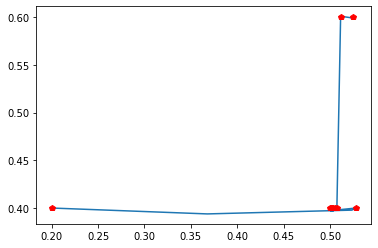

In [279]:
#function to do differitial:
def DiffPos(state,next_State,timestep):
    A = np.array([[1,0,timestep,0],
                   [0,1,0,timestep]])
    NextPos = A@state

    return NextPos




pointsBetween = 5 #number of poitns between each different part
TotalN = pointsBetween*N

Optimizer = MathematicalProgram()

#X Y Xdot Y Dot

x_step = prog.NewContinuousVariables(4,TotalN,'x_step')
timestep = prog.NewContinuousVariables(1,TotalN,'timestep')
prog.AddBoundingBoxConstraint(0.001,10,timestep)
#Add Bounce Constraints
x_bounce = np.concatenate((q_m_res[0:2,:],q_mdot_res[0:2,:]))

print(x_bounce)
for i in range(N):
    prog.AddConstraint(eq(x_step[:,i*pointsBetween], x_bounce[:,i]))


for i in range(TotalN-1):
    nextPos = DiffPos(x_step[:,i],x_step[:,i+1],timestep[0,i])
    prog.AddConstraint(eq(x_step[0:2,i+1],nextPos))
    prog.AddCost((x_step[2:,i]-x_step[2:,i+1]).dot(x_step[2:,i]-x_step[2:,i+1]))


result = Solve(prog)
x_sol = result.GetSolution(x_step)

plt.figure()
plt.plot(x_sol[0,:],x_sol[1,:])
plt.plot(q_m_res[0,:],q_m_res[1,:],'rp')



In [243]:
# Imports
import numpy as np
import altair as alt
import pydot
from IPython.display import display, SVG, clear_output
import plotly.express as px

from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, 
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MeshcatVisualizerCpp, MultibodyPlant, MultibodyPositionToGeometryPose, Parser,
    PiecewisePose, PiecewisePolynomial, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource
)
from pydrake.examples.manipulation_station import ManipulationStation


from manipulation.meshcat_cpp_utils import (
    StartMeshcat)
from manipulation.scenarios import AddMultibodyTriad, SetColor

# TODO(russt): Move this to drake (adding the element name support to the base class).
import pandas as pd
def dataframe(trajectory, times, names):
  assert trajectory.rows() == len(names)
  values = trajectory.vector_values(times)
  data = {'t': times }
  for i in range(len(names)):
    data[names[i]] = values[i,:]
  return pd.DataFrame(data)

In [244]:
meshcat = StartMeshcat()

In [280]:
times = np.cumsum(np.sum(h_res,axis=0))
print(times)
poly = PiecewisePolynomial.CubicHermite(times,q_m_res[0:3,:],q_mdot_res[0:3,:])

traj_v_G = poly.MakeDerivative()

data = dataframe(traj_v_G, np.linspace(traj_v_G.start_time(), traj_v_G.end_time()), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

[0.25653393 0.58504641 0.79430847 1.02660049 1.27269169 1.52882678
 1.79933392 2.11163057 2.56844526 2.57044526]


alt.VConcatChart(...)



time = np.cumsum(np.sum(h_res,axis=0))
xpos = np.ndarray([0,1,0],order='F')
xpos.setflags(write=True)

poly = PiecewisePolynomial.CubicHermite(breaks=time,samples=q_m_res[0:3,:],samples_dot=q_mdot_res[0:3,:])

t = np.linspace(0,time[-1],200)

plt.figure()
res = poly.vector_values(t)
der = poly.derivative()
res_der = der.vector_values(t)
plt.plot(res[0,:],res[1,:],'b-')
plt.plot(q_m_res[0,:],q_m_res[1,:],'rp')

plt.plot(q_m_res[0,-1],q_m_res[1,-1],'yp')

plt.figure()
plt.plot(res_der[0,:],res_der[1,:],'b-')
plt.plot(q_mdot_res[0,:],q_mdot_res[1,:],'rp')
plt.plot(q_mdot_res[0,-1],q_mdot_res[1,-1],'yp')

In [281]:
#We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.v_G_port = self.DeclareVectorInputPort("v_WG", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(3))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(3), 
                                     self.CalcOutput)
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
       
        V_G = self.v_G_port.Eval(context)
        
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)

            
        J_G = J_G[(3,5,1),0:3] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

In [253]:
  
  # builder = DiagramBuilder()

  # # Add ManipulationStation 
  # station = builder.AddSystem(ManipulationStation(time_step = 1e-3))
  # station.SetupPlanarIiwaStation()
  # station.Finalize()

  

In [286]:
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.65, 0.09]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.5, 0, 0.09])}

builder = DiagramBuilder()

station = builder.AddSystem(ManipulationStation())
station.SetupPlanarIiwaStation()

station.Finalize()
  


# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
plant = station.get_multibody_plant()
#display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {"initial": plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))}

x = X_G["initial"].translation()
r = X_G["initial"].rotation()

rz= RollPitchYaw(r).pitch_angle()

newTheta = q_m_res[2,:]*-1


newTime = np.concatenate(([0],times))*3
#print(newTheta.shape)
finalQ_m = np.concatenate((q_m_res[0:2,:],[newTheta]),axis =0)

propr_der= np.concatenate(([[x[0]],[x[2]],[rz]],finalQ_m),axis =1)
v_dot = np.concatenate(([[0],[0],[0]],q_mdot_res[0:3,:]),axis=1)

poly = PiecewisePolynomial.CubicHermite(newTime,propr_der,v_dot)

traj_v_G = poly.MakeDerivative()



v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
v_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))

integrator = builder.AddSystem(Integrator(3))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), 
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                controller.GetInputPort("iiwa_position"))


meshcat.Delete()
visualizer = MeshcatVisualizerCpp.AddToBuilder(
    builder, station.GetOutputPort("query_object"), meshcat)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
# TODO(russt): Add this missing python binding
#integrator.set_integral_value(
#    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
#        station.GetIiwaPosition(station_context))
integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

simulator.set_target_realtime_rate(.5)

station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
station.GetInputPort("wsg_position").FixValue(station_context, [0.08])
#meshcat.start_recording()

#meshcat.stop_recording()
#meshcat.publish_recording()


In [287]:
val = 0
#draw all of the poses here to sanity check stuff
for i in propr_der.T:
    val = val +1
    w = RotationMatrix.MakeYRotation(i[2])
    r = [i[0],0,i[1]] 
    AddMeshcatTriad(meshcat,"pos/"+ str(val),length = .15,radius = .006,X_PT=RigidTransform(w,r)) 
    

In [288]:
simulator.AdvanceTo(0.01)

In [290]:
#meshcat.start_recording()
simulator.AdvanceTo(10)
#meshcat.stop_recording()
#meshcat.publish_recording()
